# Clustering Project 

Use end to end task based learning to solve a clustering problem in the best way 

* generate data 
* solve the problem and generate paths (CVXPY)
* wrap as a layer in pytorch and optimize hyperparameters 

In [1]:
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import torch
from cvxpylayers.torch import CvxpyLayer
torch.set_default_dtype(torch.double)
np.set_printoptions(precision=3, suppress=True)
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from numpy.random import default_rng
from scipy.spatial import distance_matrix

rng = default_rng()

In [2]:
torch.manual_seed(0)
np.random.seed(0)

N = 30

p = 0.008
std = 0.7

outlier = 5
means = np.array([[2, 2], [-2, -2], [5, -1]])
(K, n) = means.shape

probs = rng.random(K)
probs = probs/probs.sum()
probs = [0.33, 0.33, 0.34]
print(probs)

groups = rng.choice(np.arange(0, K), size = N, p=probs)

means = np.array([[2, 2], [-2, -2], [5, -1]])
K = len(means)
Xtrain = []
Xtest = []
for pt in range(len(groups)):
    dist_type = groups[pt]
    Xtrain.append(means[dist_type] + std*rng.normal(size = n))
    Xtest.append(means[dist_type] + std*rng.normal(size = n))

Xtrain = np.array(Xtrain)
Xtest = np.array(Xtest)

[0.33, 0.33, 0.34]


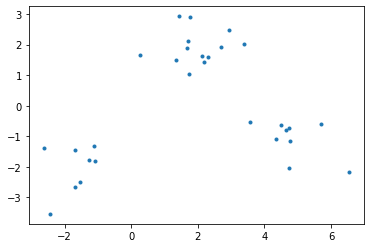

In [4]:
plt.plot(Xtrain[:,0], Xtrain[:,1], '.')

In [5]:
Xtrain, Xtest = map(torch.from_numpy, [Xtrain, Xtest])
Xtrain.requires_grad_(True)
m = Xtrain.shape[0]

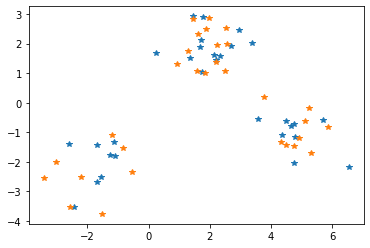

In [6]:
plt.plot(Xtrain[:,0].detach().numpy(), Xtrain[:,1].detach().numpy(), '*');
plt.plot(Xtest[:,0].detach().numpy(), Xtest[:,1].detach().numpy(), '*');

Implementing the following 
$$
\min_{\alpha \in \mathbb{R}^{m \times n}} \lambda ||\alpha - X_{train}|| +  \sum_{i \leq j} w_{ij}(\gamma) \ ||\alpha_i - \alpha_j||_q
$$

which becomes $n$ separate optimizations in the case of l1 regularization

$$
 \sum_{k = 1}^n \min_{\alpha^{(k)} \in \mathbb{R}^{m}} \lambda ||\alpha^{(k)} - X_{train}^{(k)}|| + \sum_{i \leq j} w_{ij}(\gamma) \ | \alpha_i^{(k)} - \alpha_j^{(k)}|
$$

$$
w_{ij} = \text{exp}(-\gamma ||X_i - X_j||)
$$

In [7]:

# assignment = {}
# for i in range(m):
#     for j in range(m):
#         if i < j:
#             norm = np.linalg.norm(Xtrain.detach().numpy()[i,:] - Xtrain.detach().numpy()[j,:], ord = 1)
#             assignment[(i,j)] = norm 
        
# # wij.value = assi

# a = cp.Variable((m,n))
# lamb = cp.Parameter(nonneg=True)
# gamma = 0.8
# #norm points 
# norm_points = np.quantile(list(assignment.values()), [0.33, 0.66, 1])+10**(-6)
# #calculate average norm value 
# norm_average = norm_points - np.diff(np.append(np.array([0]), norm_points))/2

# ws = cp.Parameter(len(norm_points), nonneg = True)

# ws.value = np.exp((-1)*gamma*norm_average)

# error = cp.norm(a - Xtrain.detach().numpy(), "fro")
# regularization =  0 #cp.norm(cp.hstack([a[i,:] - a[j,:]  for i in range(m) for j in range(m) if i < j]),1)

# for i in range(m):
#     for j in range(m):
#         if i < j:
#             norm = np.linalg.norm(Xtrain.detach().numpy()[i,:] - Xtrain.detach().numpy()[j,:], ord = 1)
#             index = sum(norm_points < norm)
#             #print(index)
#             regularization += ws[index]*cp.norm(a[i,:] - a[j,:], 1)
#             #np.exp((-1)*gamma*norm
# obj = cp.Minimize(lamb*error + regularization)
# prob = cp.Problem(obj)

In [7]:

assignment = np.zeros(int(m*(m-1)/2))
k = 0
indices = {}
for i in range(m):
    for j in range(m):
        if i < j:
            indices[k] = (i,j)
            norm = np.linalg.norm(Xtrain.detach().numpy()[i,:] - Xtrain.detach().numpy()[j,:], ord = 1)
            assignment[k] = norm 
            k = k+1
        
# wij.value = assi

a = cp.Variable((m,n))
lamb = cp.Parameter(nonneg=True)
gamma = 1
#norm points 

ws = cp.Parameter(int(m*(m-1)/2), nonneg = True)
ws.value =  np.exp((-1)*gamma*assignment)

error = cp.norm(a - Xtrain.detach().numpy(), "fro")
regularization =  0

for k in range(int(m*(m-1)/2)):
    #print(index)
    (i,j) = indices[k]
    regularization += ws[k]*cp.norm(a[i,:] - a[j,:], 1)
            
            
obj = cp.Minimize(lamb*error + regularization)
prob = cp.Problem(obj)

In [8]:
# Construct a trade-off curve of ||Ax-b||^2 vs. ||x||_1
sq_penalty = []
l1_penalty = []
a_values = []
lamb_vals = np.logspace(-2, 2, 40)
for val in lamb_vals:
    lamb.value = val
    prob.solve()
    # Use expr.value to get the numerical value of
    # an expression in the problem.
    sq_penalty.append(error.value)
    l1_penalty.append(regularization.value)
    a_values.append(a.value)


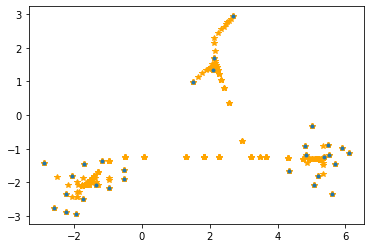

In [9]:
a_values_np = np.array(a_values)
for a_vals in a_values:
    plt.plot(a_vals[:,0], a_vals[:,1], "*", color = 'orange')
plt.plot(Xtrain[:,0].detach().numpy(), Xtrain[:,1].detach().numpy(), '.')

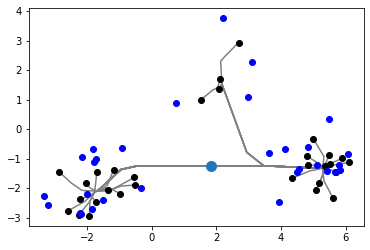

In [10]:
for i in range(m):
    points = [a_values[k][i] for k in range(len(lamb_vals))]
    x = [point[0] for point in points]
    y = [point[1] for point in points]
    plt.plot(x,y, color =  'grey')
plt.plot(Xtrain[:,0].detach().numpy(), Xtrain[:,1].detach().numpy(), 'o', color = 'black')
plt.plot(Xtrain[:,0].detach().numpy().mean(), Xtrain[:,1].detach().numpy().mean(), 'o', markersize=10)
plt.plot(Xtest[:,0].detach().numpy(), Xtest[:,1].detach().numpy(), 'o', color = 'blue')

$$
\begin{aligned}
\min_{\lambda, \gamma} \ & ||\alpha - X_{test}|| \\
\alpha & = \text{argmin}_{\alpha^{(k)} \in \mathbb{R}^{m}} \sum_{k = 1}^n ||\alpha^{(k)} - X_{train}^{(k)}|| + \lambda \sum_{i \leq j} ||\alpha_i^{(k)} - \alpha_j^{(k)}||_q
\end{aligned}
$$

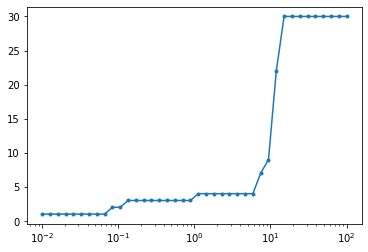

In [11]:
plt.plot(lamb_vals, [len(np.unique(a_values[i].round(3),axis = 0)) for i in range(len(lamb_vals))],".-")
plt.xscale('log')

In [12]:
# convert into pytorch layer in one line
fit_lr = CvxpyLayer(prob, [lamb, ws], [a])

In [13]:
lamb_tch, ws_tch = map(torch.from_numpy, [np.array([1.0]), ws.value])
lamb_tch.requires_grad_(True);
ws_tch.requires_grad_(True);

In [14]:
test = fit_lr(lamb_tch, ws_tch)
a_tch,  = fit_lr(lamb_tch, ws_tch)

In [15]:
# sweep over values of alpha, holding lambda=0, evaluating the gradient along the way
test_losses = []
grads = []
for lamb_val in lamb_vals:
    lamb_tch = torch.tensor([lamb_val], requires_grad=True)
    lamb_tch.grad = None
    a_tch,  = fit_lr(lamb_tch, ws_tch)
    test_loss = torch.norm(Xtest - a_tch,p='fro')
    test_loss.backward()
    test_losses.append(test_loss.item())
    grads.append(lamb_tch.grad.item())

C:\Users\David\anaconda3\envs\cvxpy\lib\site-packages\diffcp\cone_program.py:296: UserWarning: Solved/Inaccurate.
  warnings.warn("Solved/Inaccurate.")


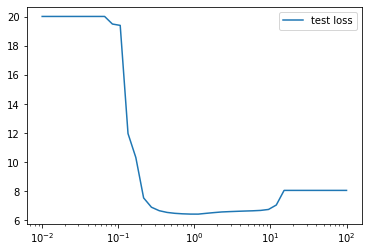

In [16]:
plt.semilogx()
plt.plot(lamb_vals, test_losses, label='test loss')
#plt.plot(lamb_vals, grads, label='analytical gradient')
plt.legend()

In [17]:
a_tch,  = fit_lr(torch.tensor([1.0]), ws_tch)

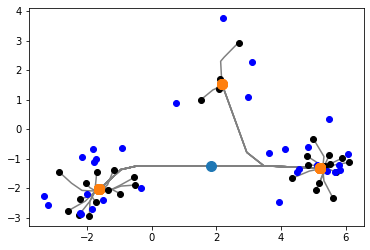

In [18]:
for i in range(m):
    points = [a_values[k][i] for k in range(len(lamb_vals))]
    x = [point[0] for point in points]
    y = [point[1] for point in points]
    plt.plot(x,y, color =  'grey')
plt.plot(Xtrain[:,0].detach().numpy(), Xtrain[:,1].detach().numpy(), 'o', color = 'black')
plt.plot(Xtrain[:,0].detach().numpy().mean(), Xtrain[:,1].detach().numpy().mean(), 'o', markersize=10)
plt.plot(Xtest[:,0].detach().numpy(), Xtest[:,1].detach().numpy(), 'o', color = 'blue')
plt.plot(a_tch[0,:,0].detach().numpy(), a_tch[0,:,1].detach().numpy(), 'o', markersize=10)

In [19]:
params = [lamb_tch]

def loss_fn(X):
    a_tch,  = fit_lr(lamb_tch, ws_val)
    loss = torch.norm(X - a_tch,p='fro')
    return loss

In [20]:
m = len(Xtrain)

In [21]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, fit_lr):
        super(Net, self).__init__()
        self.pdist = nn.functional.pdist
        self.Relu = nn.ReLU()
        self.gamma = nn.Parameter(torch.tensor([1.0]))
        self.lamb_tch = nn.Parameter(torch.tensor([1.0]))
#         self.lamb_tch.requires_grad_(True);
#         self.ws_tch.requires_grad_(True);    
        self.cvx_lr = fit_lr
        
    # X represents our data
    def forward(self, X):

        #calculate pairwise distances
        norms = self.pdist(X)
        gamma_pos = self.Relu(self.gamma)
        lamb_tch_pos = self.Relu(self.lamb_tch)
        ws_tch = torch.exp(torch.mul(norms, (-1.0)*gamma_pos))
        # Use the rectified-linear activation function over x
        a_tch = self.cvx_lr(lamb_tch_pos, ws_tch)
        
        return a_tch[0]


In [22]:
net = Net(fit_lr)
net.parameters()

<generator object Module.parameters at 0x0000026E1B2255F0>

In [23]:
def loss(X,pred):
    return torch.norm(X - pred, p='fro')

opt = torch.optim.Adam(net.parameters(), lr=1e-2)
for _ in range(40):
    opt.zero_grad()
    l = loss(Xtest, net(Xtrain))
    print(l.item())
    l.backward()
    opt.step()

7.3300390441769485
7.181025120012131
7.063709176821096
6.970053849217385
6.894340846889958
6.832451929435977
6.781375847242198
6.738839638449963
6.703137263485095
6.6729379067428525
6.647216071842007
6.625167788518695
6.606157009685026
6.589679304749151
6.575318047266783
6.562749040465009
6.551691585327201
6.541927352847057
6.5332694708200325
6.525562406867916
6.518677446330987
6.512506153382011
6.506955322207755
6.501947140263613
6.497413710717861
6.493299016563727
6.48955355794101
6.486135115619023
6.483007219113789
6.480137847146588
6.477496834157544
6.475064033051067
6.472815064787839
6.47073352722599
6.468800843207433
6.4670025923149135
6.465328211721039
6.463762242015903
6.462297330258115
6.460923721262778


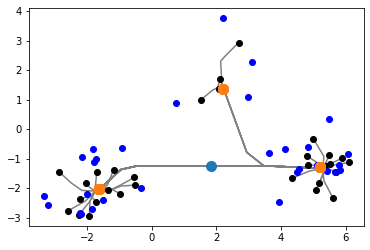

In [24]:
for i in range(m):
    points = [a_values[k][i] for k in range(len(lamb_vals))]
    x = [point[0] for point in points]
    y = [point[1] for point in points]
    plt.plot(x,y, color =  'grey')
plt.plot(Xtrain[:,0].detach().numpy(), Xtrain[:,1].detach().numpy(), 'o', color = 'black')
plt.plot(Xtrain[:,0].detach().numpy().mean(), Xtrain[:,1].detach().numpy().mean(), 'o', markersize=10)
plt.plot(Xtest[:,0].detach().numpy(), Xtest[:,1].detach().numpy(), 'o', color = 'blue')
pred = net(Xtrain)
plt.plot(pred[0,:,0].detach().numpy(), pred[0,:,1].detach().numpy(), 'o', markersize=10)

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from cvxpylayers.torch import CvxpyLayer

torch.set_default_dtype(torch.double)

from tqdm.notebook import tqdm


def fit(loss, params, X , Xval, batch_size=128, lr=1e-3, epochs=100, verbose=False, print_every=1, callback=None):
    """

    Arguments:
        loss: given x and y in batched form, evaluates loss.
        params: list of parameters to optimize.
        X: input data, torch tensor.
       
        Xval: input validation data, torch tensor.
      
    """

    train_dset = TensorDataset(X, Y)
    train_loader = DataLoader(train_dset, batch_size=batch_size, shuffle=True)
    opt = torch.optim.Adam(params, lr=lr)

    train_losses = []
    val_losses = []
    for epoch in tqdm(range(epochs)):
        if callback is not None:
            callback()
            
        with torch.no_grad():
            val_losses.append(loss(Xval, Yval).item())
        if verbose and epoch % print_every == 0:
            print("val loss %03d | %3.5f" % (epoch + 1, val_losses[-1]))

        batch = 1
        train_losses.append([])
        for Xbatch, Ybatch in train_loader:
            opt.zero_grad()
            l = loss(Xbatch, Ybatch)
            l.backward()
            opt.step()
            train_losses[-1].append(l.item())
            if verbose and epoch % print_every == 0:
                print("batch %03d / %03d | %3.5f" %
                      (batch, len(train_loader), np.mean(train_losses[-1])))
            batch += 1
    return val_losses, train_losses